In [1]:
# from pathlib import Path
# import pandas as pd
# from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs

# def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
#     logs = []
#     for p in paths:
#         fn = Path(p) / "trajectory.parquet"
#         if not fn.is_file():
#             fn = Path(p) / "logs.parquet"
#         logs.append(pd.read_parquet(fn))

#     df = pd.concat(logs).reset_index(drop=True)
#     df_cfg = pd.concat([pd.read_parquet(Path(p) / "logs_cfg.parquet") for p in paths]).reset_index(drop=True)
#     df["set"] = set_id
#     return df, df_cfg

# scenario = "blackbox"
# set_id = "full"
# paths = ["../runs/SMAC3-BlackBoxFacade", "../runs/RandomSearch", "../runs/Nevergrad-CMA-ES"]

# D = []
# for rundir in paths:
#     df, df_cfg = load_set([rundir], set_id="full")
#     D.append(df)

# df = pd.concat(D).reset_index(drop=True)
# del D

# df = normalize_logs(df)

# normalize_performance = False
# perf_col = "trial_value__cost_inc_norm" if normalize_performance else "trial_value__cost_inc"

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from carps.utils.pareto_front import pareto

def read_set(fn: Path) -> pd.DataFrame:
    df = pd.read_csv(fn)
    df["problem_id"] = df["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
    df["benchmark_id"] = df["problem_id"].apply(lambda x: x.split("/")[0])
    df = df.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")    
    return df

performance_fn = Path("/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/BB/default/df_crit.csv")
performance = pd.read_csv(performance_fn)
performance["problem_id"] = performance["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
problem_ids = list(performance["problem_id"])
n_problems = len(problem_ids)
subset_size = 30

rankings = []

performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
p_cols = [c for c in performance.columns if c not in ["problem_id", "benchmark_id"]]
performance = performance.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")


path_subset_dev = performance_fn.parent / f"subset_{subset_size}.csv"
subset_dev = read_set(path_subset_dev)

path_subset_test = performance_fn.parent / f"subset_complement_subset_{subset_size}.csv"
subset_test = read_set(path_subset_test)

problem_ids_dev = subset_dev["problem_id"].to_list()
problem_ids_test = subset_test["problem_id"].to_list()

seeds = np.arange(0, 10)
performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
benchmark_ids = list(performance["benchmark_id"].unique())


def add_rank(df: pd.DataFrame) -> pd.DataFrame:
    D = []
    for problem_id, gdf in df.groupby(["problem_id"]):
        pivot = gdf.pivot(index=["problem_id", "benchmark_id"], columns="optimizer_id", values="performance").reset_index()
        if not all([p in pivot.columns for p in p_cols]):
            print(gdf.columns)
            continue
        rank = pivot[p_cols].rank(axis=1).melt(value_vars=p_cols, var_name="optimizer_id", value_name="rank")
        gdf = pd.merge(gdf, rank, on=["optimizer_id"])
        D.append(gdf)
    D = pd.concat(D).reset_index(drop=True)
    return D

def get_ranking(df: pd.DataFrame, set_id: str, split: int = -1, seed: int = -1) -> pd.DataFrame:
    df = add_rank(df)
    df["set"] = set_id
    df["split"] = split
    df["seed"] = seed
    return df


rankings = []

aggregate_func = np.mean

mean_ranking_full = get_ranking(performance, "full")
rankings.append(mean_ranking_full)

mean_ranking_dev = get_ranking(subset_dev, "discrepancy_dev")
rankings.append(mean_ranking_dev)

mean_ranking_test = get_ranking(subset_test, "discrepancy_test")
rankings.append(mean_ranking_test)  

n_splits = n_problems // (subset_size * 2)
print(n_splits)
X = performance.values
y = performance["benchmark_id"].to_numpy()

split_classes = [StratifiedShuffleSplit, ShuffleSplit]

# for split_class in split_classes:
#     for seed in seeds:
#         sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
#         sss.get_n_splits(X, y)
#         for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#             D_dev = performance.iloc[train_index]
#             D_dev = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
#             rankings.append(D_dev)

#             D_test = performance.iloc[test_index]
#             D_test = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
#             rankings.append(D_test)


df_ranking = pd.concat(rankings).reset_index(drop=True)

38


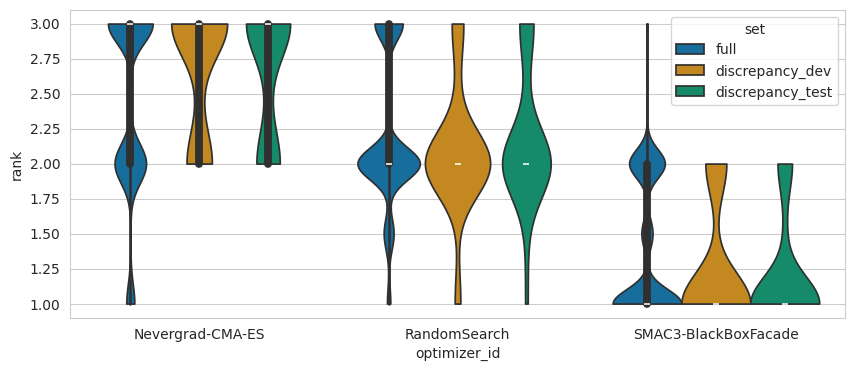

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")

gdf = df_ranking
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax = sns.violinplot(data=gdf, x="optimizer_id", y="rank", hue="set", cut=0, ax=ax)
# ax.set_title(f"use_mean: {gid}")
plt.show()

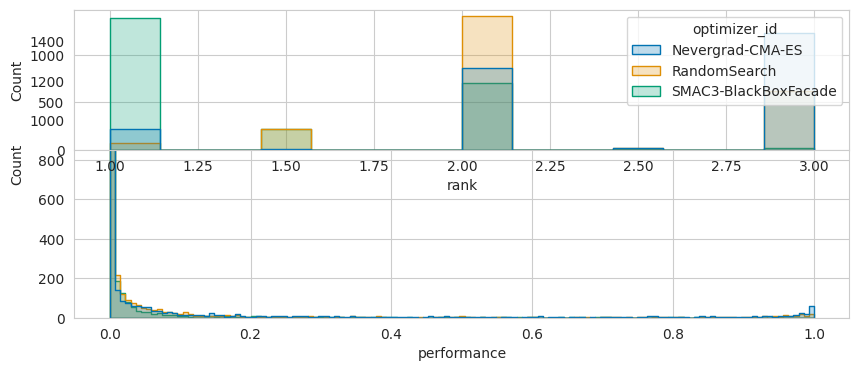

In [4]:
gdf = df_ranking
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax = sns.histplot(data=gdf, x="performance", hue="optimizer_id", ax=ax,  element="step")
ax = fig.add_subplot(211)
ax = sns.histplot(data=gdf, x="rank", hue="optimizer_id", ax=ax,  element="step")
# ax.set_title(f"use_mean: {gid}")
plt.show()

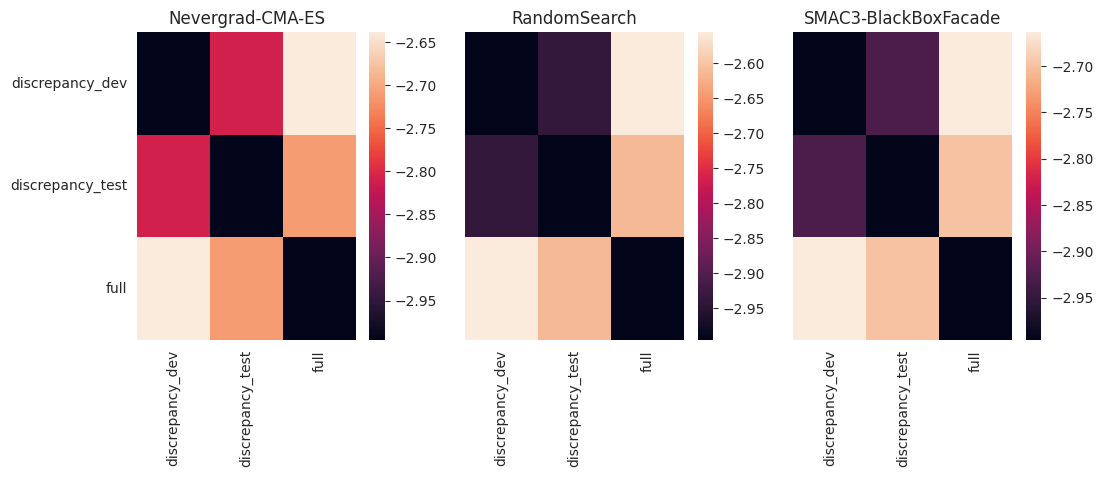

In [5]:
def distance_bhattacharaya(p, q):
    return -np.log(np.sum(np.sqrt(p*q)))

def distance_kullback_leibler(p, q):
    return np.sum(p * np.log(p / q))

# Performance
distances = {}
bin_edges = None
for gid, gdf in df_ranking.groupby(["optimizer_id", "set"]):
    values = gdf["performance"].values
    q = np.histogram(values, bins=20, range=[0,1], density=True)
    bin_edges = q[1]
    distances[gid] = q[0]

distributions = pd.DataFrame(distances).T
distributions.index.name = ("optimizer_id", "set")
distributions = distributions.reset_index(names=["optimizer_id", "set"])
# print(distributions.columns)

dist = {}
for gid, gdf in distributions.groupby(by=["optimizer_id", "set"]):
    for gid2, gdf2 in distributions.groupby(by=["optimizer_id", "set"]):
        if gid[0] != gid2[0]:
            continue
        p = gdf.iloc[0].values[2:].astype(float)
        q = gdf2.iloc[0].values[2:].astype(float)
        d = distance_bhattacharaya(p, q)
        # print(f"{gid} vs {gid2}: {d}")
        dist[(gid, gid2)] = d

heatmaps = {}
n_sets = distributions["set"].nunique()
sets = distributions["set"].unique()
for ((opt, set_id), (opt, set_id2)), distance in dist.items():
    # print(f"{opt} {set_id} vs {set_id2}: {distance}") 
    if not opt in heatmaps:
        heatmaps[opt] = np.zeros((n_sets, n_sets))
    heatmaps[opt][np.where(sets == set_id)[0][0], np.where(sets == set_id2)[0][0]] = distance

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, len(heatmaps), sharex=True, sharey=True)
for i, (opt, heatmap) in enumerate(heatmaps.items()):
    ax = axes[i]
    sns.heatmap(heatmap, ax=ax, xticklabels=sets, yticklabels=sets)
    ax.set_title(opt)
plt.show()

In [6]:


 
# for use_mean in [False]:
#     aggregate_func = lambda x: x
#     if use_mean:
#         aggregate_func = np.mean

    

#     mean_ranking_full = performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_full = performance[p_cols]
#     mean_ranking_full["problem_id"] = performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_full["set"] = "full"
#     mean_ranking_full["split"] = -1
#     mean_ranking_full["seed"] = -1
#     mean_ranking_full["use_mean"] = use_mean
#     mean_ranking_full = melt(mean_ranking_full)
#     mean_ranking_full = add_performance(mean_ranking_full)
    

#     mean_ranking_dev = subset_dev[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_dev["problem_id"] = subset_dev["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_dev["set"] = "discrepancy_dev"
#     mean_ranking_dev["split"] = -1
#     mean_ranking_dev["seed"] = -1
#     mean_ranking_dev["use_mean"] = use_mean
#     mean_ranking_dev = melt(mean_ranking_dev)
#     mean_ranking_dev = add_performance(mean_ranking_dev)

#     mean_ranking_test = subset_test[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_test["problem_id"] = subset_test["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_test["set"] = "discrepancy_test"
#     mean_ranking_test["split"] = -1
#     mean_ranking_test["seed"] = -1
#     mean_ranking_test["use_mean"] = use_mean
#     mean_ranking_test = melt(mean_ranking_test)
#     mean_ranking_test = add_performance(mean_ranking_test)

#     # easiest
#     costs = performance[p_cols].values
#     ids = pareto(-costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_easiest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_easiest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_easiest["set"] = "pareto_full_easiest"
#     mean_ranking_pareto_easiest["split"] = -1
#     mean_ranking_pareto_easiest["seed"] = -1
#     mean_ranking_pareto_easiest["use_mean"] = use_mean
#     mean_ranking_pareto_easiest = melt(mean_ranking_pareto_easiest)
#     mean_ranking_pareto_easiest = add_performance(mean_ranking_pareto_easiest)

#     # hardest
#     costs = performance[p_cols].values
#     ids = pareto(costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_hardest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_hardest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_hardest["set"] = "pareto_full_hardest"
#     mean_ranking_pareto_hardest["split"] = -1
#     mean_ranking_pareto_hardest["seed"] = -1
#     mean_ranking_pareto_hardest["use_mean"] = use_mean
#     mean_ranking_pareto_hardest = melt(mean_ranking_pareto_hardest)
#     mean_ranking_pareto_hardest = add_performance(mean_ranking_pareto_hardest)



#     ranking = []
#     ranking.append(mean_ranking_full)
#     ranking.append(mean_ranking_dev)
#     ranking.append(mean_ranking_test)
#     ranking.append(mean_ranking_pareto_easiest)
#     ranking.append(mean_ranking_pareto_hardest)

#     n_splits = n_problems // (subset_size * 2)
#     print(n_splits)
#     X = performance.values
#     y = performance["benchmark_id"].to_numpy()

#     split_classes = [StratifiedShuffleSplit, ShuffleSplit]

#     for split_class in split_classes:
#         for seed in seeds:
#             sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
#             sss.get_n_splits(X, y)
#             for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#                 D_dev = performance.iloc[train_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_dev["problem_id"] = performance.iloc[train_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_dev["set"] = f"{split_class.__name__}_dev"
#                 D_dev["split"] = i
#                 D_dev["seed"] = seed
#                 D_dev["use_mean"] = use_mean
#                 D_dev = melt(D_dev)
#                 D_dev = add_performance(D_dev)
                
#                 D_test = performance.iloc[test_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_test["problem_id"] = performance.iloc[test_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_test["set"] = f"{split_class.__name__}_test"
#                 D_test["split"] = i
#                 D_test["seed"] = seed
#                 D_test["use_mean"] = use_mean
#                 D_test = melt(D_test)
#                 D_test = add_performance(D_test)
#                 ranking.extend([D_dev, D_test])

#     df_ranking = pd.DataFrame(ranking) if use_mean else pd.concat(ranking).reset_index(drop=True)
#     df_ranking = df_ranking.melt(id_vars=["set", "split", "seed", "problem_id", "use_mean"], value_vars=p_cols, var_name="optimizer_id", value_name="rank")
#     rankings.append(df_ranking)

# df_ranking = pd.concat(rankings).reset_index(drop=True)
# df_ranking
